  0%|                                                  | 0/365 [00:00<?, ?it/s]

(375, 450)
(375, 450)


100%|████████████████████████████████████████| 365/365 [11:16<00:00,  1.85s/it]


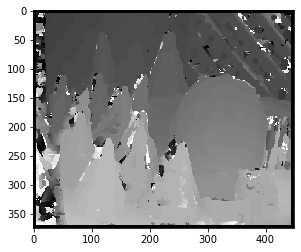

In [3]:
import cv2
import numpy as np
from tqdm import *
import matplotlib.pyplot as plt

BLOCK_SIZE = 10
SEARCH_BLOCK_SIZE = 70
left_image_path="im2.png"
right_image_path="im6.png"

def _read_left_right_image_pair(left_image_path=left_image_path,
                                right_image_path=right_image_path):
    # Load an color image in grayscale
    left_im = cv2.imread(left_image_path, 0)
    right_im = cv2.imread(right_image_path, 0)
    # Convert image to array
    left_im_array = np.asarray(left_im)
    right_im_array = np.asarray(right_im)
    print(left_im_array.shape)
    print(right_im_array.shape)

    return left_im_array, right_im_array


def compare_blocks(y, x, block_left, right_array, block_size=BLOCK_SIZE):
    """
    Compare left block of pixels with multiple blocks from the right
    image using SEARCH_BLOCK_SIZE to constrain the search in the right
    image.
    Args:
        y (int): row index of the left block
        x (int): column index of the left block
        block_left (numpy.ndarray): containing pixel values within the 
                    block selected from the left image
        right_array (numpy.ndarray]): containing pixel values for the 
                     entrire right image
        block_size (int, optional): Block of pixels width and height. 
                                   #Can be smaller/BLOCK_SIZE
    Returns:
        tuple: (y, x) row and column index of the best matching block 
                in the right image
    """
    # Get search range for the right image
    x_min = max(int(block_size/2), x - SEARCH_BLOCK_SIZE)
    x_max = min(right_array.shape[1]-int(block_size/2), x + SEARCH_BLOCK_SIZE)
    first = True
    min_sad = None
    min_index = None
    for x in range(x_min, x_max):
        block_right = right_array[y-int(block_size/2): y+int(block_size/2),
                                  x-int(block_size/2): x+int(block_size/2)]
        
        if block_left.shape != block_right.shape:
            return -1
        else:
            sad = np.sum(abs(block_left - block_right))
        
        if first:
            min_sad = sad
            min_index = (y, x)
            first = False
        else:
            if sad < min_sad:
                min_sad = sad
                min_index = (y, x)

    return min_index

#get_disparity_map
left_array, right_array = _read_left_right_image_pair()
left_array = left_array.astype(int)
right_array = right_array.astype(int)
if left_array.shape != right_array.shape:
    raise "Left-Right image shape mismatch!"
h, w = left_array.shape
disparity_map = np.zeros((h, w))
# Go over each pixel position
for y in tqdm(range(int(BLOCK_SIZE/2), h-int(BLOCK_SIZE/2))):
    for x in range(int(BLOCK_SIZE/2), w-int(BLOCK_SIZE/2)):
        block_left = left_array[y-int(BLOCK_SIZE/2):y + int(BLOCK_SIZE/2),
                                x-int(BLOCK_SIZE/2):x + int(BLOCK_SIZE/2)]
        min_index = compare_blocks(y, x, block_left,
                                   right_array,
                                   block_size=BLOCK_SIZE)
        disparity_map[y, x] = (min_index[1] - x)

disparity_map = np.uint8(abs(disparity_map))      

plt.imshow(disparity_map, cmap='gray', interpolation='nearest')
plt.savefig('depth_image.png')
plt.show()

generating 3d point cloud...
Points_Cloud.ply saved


True

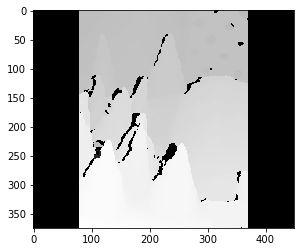

In [4]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

imgL= 'im2.png'
imgR= 'im6.png'

img1_undistorted = cv.imread(imgL, 0)
img2_undistorted = cv.imread(imgR, 0)

#Can by opened by Meshlab
ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''

def write_ply(fn, verts, colors):
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    verts = np.hstack([verts, colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

#https://docs.opencv.org/4.5.2/d2/d85/classcv_1_1StereoSGBM.html

# Matched block size. It must be an odd number >=1 . Normally, it should be somewhere in the 3..11 range.
block_size = 7
min_disp = -80
max_disp = 80
# Maximum disparity minus minimum disparity. The value is always greater than zero.
# In the current implementation, this parameter must be divisible by 16.
num_disp = max_disp - min_disp
# Margin in percentage by which the best (minimum) computed cost function value should "win" the second best value to consider the found match correct.
# Normally, a value within the 5-15 range is good enough
uniquenessRatio = 5
# Maximum size of smooth disparity regions to consider their noise speckles and invalidate.
# Set it to 0 to disable speckle filtering. Otherwise, set it somewhere in the 50-200 range.
speckleWindowSize = 50
# Maximum disparity variation within each connected component.
# If you do speckle filtering, set the parameter to a positive value, it will be implicitly multiplied by 16.
# Normally, 1 or 2 is good enough.
speckleRange = 1
disp12MaxDiff = 2

stereo = cv.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=block_size,
    uniquenessRatio=uniquenessRatio,
    speckleWindowSize=speckleWindowSize,
    speckleRange=speckleRange,
    disp12MaxDiff=disp12MaxDiff,
    P1=8 * 1 * block_size * block_size,
    P2=32 * 1 * block_size * block_size,
)
disp = stereo.compute(img1_undistorted, img2_undistorted)

# Normalize the values to a range from 0..255 for a grayscale image
disparity_SGBM = cv.normalize(disp, disp, alpha=255,
                              beta=0, norm_type=cv.NORM_MINMAX)
disparity_SGBM = np.uint8(disparity_SGBM)

print('generating 3d point cloud...',)
h, w = img1_undistorted.shape[:2]
f = 0.8*w                          # guess for focal length
Q = np.float32([[1, 0, 0, -0.5*w],
                [0,-1, 0,  0.5*h], # turn points 180 deg around x-axis,
                [0, 0, 0,     -f], # so that y-axis looks up
                [0, 0, 1,      0]])
points = cv.reprojectImageTo3D(disp, Q)
colors = cv.cvtColor(cv.imread(imgL), cv.COLOR_BGR2RGB)
mask = disp > disp.min()
out_points = points[mask]
out_colors = colors[mask]
out_fn = 'Points_Cloud.ply'
write_ply(out_fn, out_points, out_colors)
print('%s saved' % out_fn)
    
plt.imshow(disparity_SGBM, cmap ='gray')
cv.imwrite("disparity_SGBM_norm.png", disparity_SGBM)

In [ ]:
# StereoSGBM Parameter explanations: https://docs.opencv.org/4.5.0/d2/d85/classcv_1_1StereoSGBM.html
#https://www.andreasjakl.com/how-to-apply-stereo-matching-to-generate-depth-maps-part-3/
#https://docs.opencv.org/master/d3/d14/tutorial_ximgproc_disparity_filtering.html

In [5]:
#♣point cloud viewer: https://heremaps.github.io/pptk/viewer.html
import pptk
import numpy as np
import plyfile

data = plyfile.PlyData.read('Points_Cloud.ply')['vertex']

xyz = np.c_[data['x'], data['y'], data['z']]
rgb = np.c_[data['red'], data['green'], data['blue']]
#n = np.c_[data['nx'], data['ny'], data['nz']]

v = pptk.viewer(xyz)
v.attributes(rgb / 255.)#, 0.5 * (1 + n)
v.set(point_size=0.01)